# Results Plotting
Notebook for plotting summary results for E-VRP.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [63]:
# Import cost per mile results
cpm_fpath = Path("/Users/ramiariss/Projects/E-VRP-TW-V2G/output/all_blended_cpm.csv")
cpm_df = pd.read_csv(cpm_fpath)

# Clean up the dataframe
cpm_df.drop_duplicates(inplace=True)
cpm_df.drop(columns=["Instance"], inplace=True)

# Replace NaNs
cpm_df["EV Type"].fillna(cpm_df["Vehicle Type"], inplace=True)  # Replace NaN EV Type with Vehicle Type
cpm_df["Tariff Type"].fillna("N/A", inplace=True)  # Replace NaN Tariff Type with None

# Replace NorCal with Northern California and SoCal with Southern California
cpm_df["Region"] = cpm_df["Region"].replace({"NorCal": "Northern California", "SoCal": "Southern California"})

# Replace EV Types with more descriptive names
cpm_df["EV Type"] = cpm_df["EV Type"].replace({
    "Diesel": "Diesel",
    "Charge": "Coordinated Charging",
    "Worst": "Uncoordinated Charging",
    "V2G": "Coordinated V2G",
})

# Replace Scenarios with more descriptive names
cpm_df["Scenario"] = cpm_df["Scenario"].replace({
    "Diesel High": "Pessimistic",
    "Diesel High-Ref": "Slightly Pessimistic",
    "Diesel Ref": "Realistic",
    "Diesel Low-Ref": "Slightly Optimistic",
    "Diesel Low": "Optimistic",
    "High": "Pessimistic",
    "Ref": "Realistic",
    "Low": "Optimistic",
})

In [64]:
cpm_df

,Vehicle Type,EV Type,Tariff Type,Region,Scenario,Total Cost per Mile
0,Diesel,Diesel,N/A,Southern California,Pessimistic,2.836116
1,Diesel,Diesel,N/A,China,Pessimistic,2.920560
2,Diesel,Diesel,N/A,Northern California,Pessimistic,2.961444
3,Diesel,Diesel,N/A,Texas,Pessimistic,2.877481
4,Diesel,Diesel,N/A,East Coast,Pessimistic,3.018545
...,...,...,...,...,...,...
89,EV,Uncoordinated Charging,All Demand,Southern California,Pessimistic,8.886637
90,EV,Uncoordinated Charging,All Demand,China,Pessimistic,3.575234
91,EV,Uncoordinated Charging,All Demand,Northern California,Pessimistic,13.351898
92,EV,Uncoordinated Charging,All Demand,Texas,Pessimistic,5.180351


In [65]:
# Extract key plotting parameters from df
regions = cpm_df["Region"].unique()
vehicle_types = cpm_df["Vehicle Type"].unique()
ev_types = cpm_df["EV Type"].unique()
tariff_types = cpm_df["Tariff Type"].unique()
scenarios = cpm_df["Scenario"].unique()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

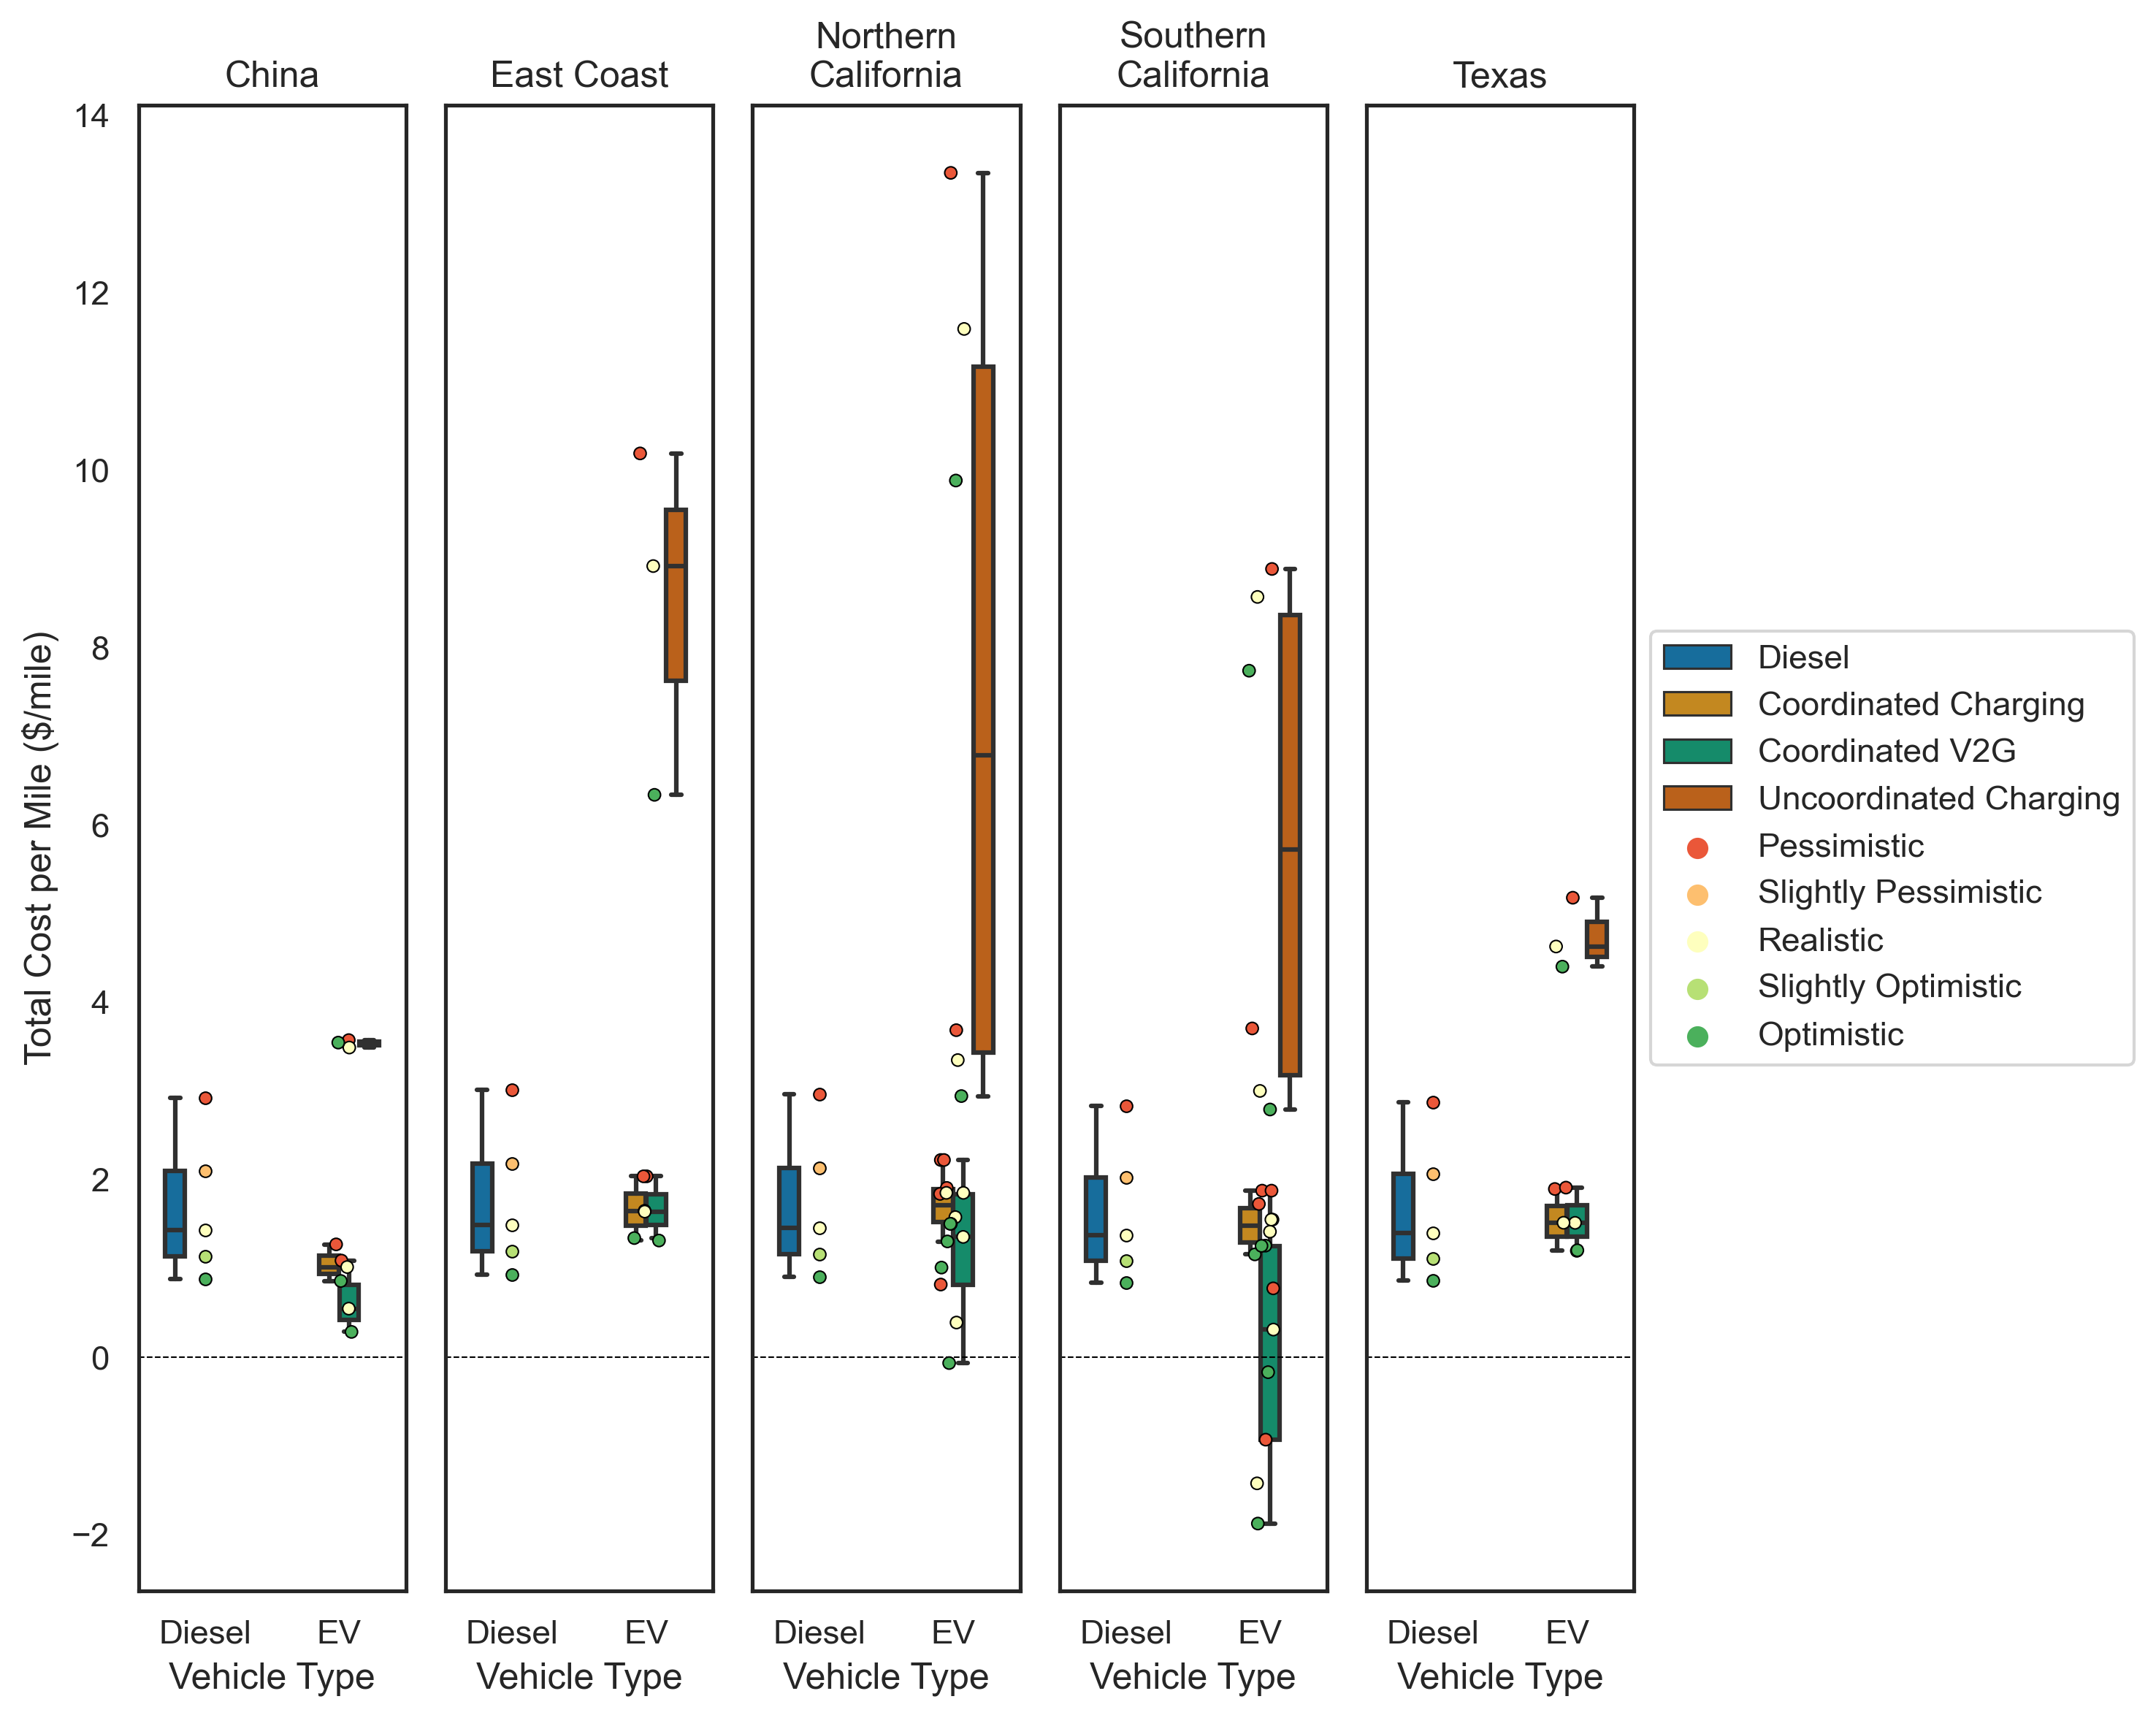

In [76]:
save_plot = True

sns.set_theme(style="white", palette="colorblind")

fig, ax = plt.subplots(1, len(regions), figsize=(10, 8), dpi=300, sharey=True)

# Set a red to green color palette for the Scenario
scenarios_palette = sns.color_palette("RdYlGn", 5)
scenario_to_scenario_palette = dict(zip(scenarios, scenarios_palette))

regions.sort()  # Sort regions alphabetically
for region_idx, region in enumerate(regions):
    # Extract region dataframe
    region_df = cpm_df[cpm_df["Region"] == region]
                        
    # Plot boxplot for each region
    sns.boxplot(data=region_df, x="Vehicle Type", y="Total Cost per Mile", hue="EV Type", width = 0.6, ax=ax[region_idx])
    
    # Plot all points on top of boxplot, color them by the scenario with the scenario color palette; add them to a separated legend
    for scenario in scenarios:
        scenario_df = region_df[region_df["Scenario"] == scenario]
        sns.stripplot(data=scenario_df, x="Vehicle Type", y="Total Cost per Mile", hue="Scenario", palette=scenario_to_scenario_palette, dodge=False,size=4, alpha=1., edgecolor="black", linewidth=0.5, ax=ax[region_idx])
    
    # Annotate each point with its cost per mile value (-$#.##)
    # for j, point in region_df.iterrows():
    #     ax[region_idx].text(point["Vehicle Type"], point["Total Cost per Mile"], f"{point['Total Cost per Mile']:.2f}", ha="center", va="bottom", fontsize=6)
    
    # Add region label to each subplot
    title = region if "California" not in region else region.replace(" ", "\n")  # Break California into two lines
    ax[region_idx].set_title(title)
    
    # Remove y-axis title except for first subplot
    if region_idx > 0:
        ax[region_idx].set_ylabel("")
    else:
        ax[region_idx].set_ylabel("Total Cost per Mile ($/mile)")
        
    # Put a single legend for all subplots
    if region_idx == len(regions) - 1:
        ax[region_idx].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    else:
        ax[region_idx].get_legend().remove()

    # Add a horizontal line at $0/mile spanning all subplots
    ax[region_idx].axhline(0, color="black", linestyle="--", linewidth=0.5)

plt.tight_layout()

# Save plot
if save_plot:
    plot_fpath = cpm_fpath.parent / "cost_per_mile_boxplot.png"
    plt.savefig(plot_fpath, bbox_inches="tight")